In [233]:
# !pip install pandas
# !pip install pyyaml
# !pip install hpo3

In [234]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from pyhpo import Ontology, HPOSet, Omim, stats, Gene
import scipy.cluster
from matplotlib import pyplot as plt

Ontology(os.path.join(os.getcwd(), 'phenotype', 'rawdl_20240310'))

In [235]:
# Declare the folder path for phenotype data source
phenotype_folder = os.path.join(os.getcwd(), 'phenotype', 'subset')

# Declare database useds for mapping
icd10omim = 'icd102omim_subset.tsv'
loinc2hpo = 'loinc2hpo_standardized.tsv'
orpha2omim = 'orpha2omim_subset.tsv'
snomed2hpo = 'snomed2hpo_subset.tsv'
snomed2orpha = 'snomed2orpha_subset.tsv'

# iderare yaml configuration file
yaml_file = 'iderare.yaml'

# Clinical data dummy in txt format separated with new line
clinical_data = 'clinical_data.txt'

# Read the clinical data and parse the data
icd10omim_df = pd.read_csv(os.path.join(phenotype_folder, icd10omim), sep='\t')
loinc2hpo_df = pd.read_csv(os.path.join(phenotype_folder, loinc2hpo), sep='\t')
orpha2omim_df = pd.read_csv(os.path.join(phenotype_folder, orpha2omim), sep='\t')
snomed2hpo_df = pd.read_csv(os.path.join(phenotype_folder, snomed2hpo), sep='\t')
snomed2orpha_df = pd.read_csv(os.path.join(phenotype_folder, snomed2orpha), sep='\t')

# Setup similarity threshold, and number of n-top differential / alternative diagnoses 
threshold = 0.5
diffx = 10

# Read line from clinical_data and parse the data to list
with open(clinical_data, 'r') as file:
    clinical_data_list = file.read().splitlines()

In [236]:
# Convert SNOMED to ORPHA First
def snomed_orpha_parser(clinical_data, df):
    print('Trying to parse ORPHA from SNOMED-CT', clinical_data)
    
    if 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['code'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with ORPHA, please check the SNOMED to ORPHA for diagnosis mapping.')
            snomed_sugg = df[df['code'].str.contains(clinical_data.strip('SNOMEDCT:'))]['code'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_orpha = df[df['code'] == clinical_data]['orphanet_map'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_orpha), ' ORPHA code : ', (', ').join(snomed_orpha), '\n')
            return snomed_orpha
        
    else :
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Allowable format : SNOMEDCT disorder semantic only SNOMEDCT:1212005', '\n')
        return []

In [237]:
# HPO Parser for Clinical Finding Related Terminology such as SNOMED, LOINC
def hpo_parser(clinical_data, df):    
    print('Trying to parse HPO from terminology', clinical_data)
    
    # LOINC case
    if 'LOINC:' in clinical_data:
        loinc_split = clinical_data.split('|')
        # Ensure that the forwarded data contain both LOINC and its interpretation
        if len(loinc_split) == 2:
            loinc = loinc_split[0]
            interpretation = loinc_split[1]
            
            # Handling if LOINC code not found in the database
            if loinc not in df['loinc'].unique() :
                print('LOINC data is not found in the database, please check the exact LOINC code.')
                loinc_sugg = df[df['loinc'].str.contains(loinc.strip('LOINC:'))]['loinc'].drop_duplicates()
                print('Did you mean any of this code:', (', ').join(loinc_sugg.values) , '?\n')
                return []
            
            loinc_hpo = df[df['loinc'] == loinc]

            # Handling if interpretation not suitable for the LOINC code
            if interpretation not in loinc_hpo['interpretation'].unique() :
                print('Interpretation is invalid, please check if you have used correct interpretation.')
                interpretation_sugg = df[df['loinc']==loinc]['interpretation'].drop_duplicates()
                print('Available interpretation for code', loinc, ' : ', (' or ').join(interpretation_sugg.values) , '\n')
                return []
            
            loinc_hpo = loinc_hpo[loinc_hpo['interpretation'] == interpretation]['hpoTermId'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', loinc_hpo, '\n')
            return list(loinc_hpo)
        else:
            print('LOINC data is missing either code / interpretation.')
            print('Example : LOINC:721-1|H for Qn lab examination OR LOINC:721-1|NEG for Nominal / Ordinal Lab Examination', '\n')
            return []
        
    # SNOMED-CT case
    elif 'SNOMEDCT:' in clinical_data:
        if clinical_data not in df['SNOMED_CT_ID'].unique() :
            print('This SNOMED-CT code is not a clinical finding mapped with HPO, please check the SNOMED to OMIM for diagnosis mapping.')
            snomed_sugg = df[df['SNOMED_CT_ID'].str.contains(clinical_data.strip('SNOMEDCT:'))]['SNOMED_CT_ID'].drop_duplicates()
            print('Sugggestion : It is possible that you mean any of this code:', (', ').join(snomed_sugg.values) , '?\n')
            return []
        else : 
            snomed_hpo = df[df['SNOMED_CT_ID'] == clinical_data]['HPO_ID'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(snomed_hpo), ' HPO code : ', (', ').join(snomed_hpo), '\n')
            return list(snomed_hpo)
        
    # Not recognized case
    else:
        print('The terminology is not recognized, please check if you have used correct terminology.')
        print('Example : LOINC:2862-1|L for Qn lab examination OR LOINC:725-2|NEG for categoric lab examination of SNOMEDCT:48610005 for Clinical Finding', '\n')
        return []

In [238]:
# OMIM Parser used for diagnosis related terminology ICD-10, ORPHA, SNOMED-CT to be translated to OMIM
def omim_parser(clinical_data,df):
    print('Trying to parse OMIM from terminology', clinical_data)

    # ICD-10 case
    if 'ICD-10:' in clinical_data:
        if clinical_data not in df['ICD10'].unique() :
            print('ICD-10 data is not found in the database, please check the exact ICD-10 code.')
            icd_sugg = df[df['ICD10'].str.contains(clinical_data.strip('ICD-10:'))]['ICD10'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(icd_sugg.values) , '?\n')
            return []
        else : 
            icd_omim = df[df['ICD10'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(icd_omim), ' OMIM code : ', (', ').join(icd_omim), '\n')
            return icd_omim
        
    # ORPHA case
    elif 'ORPHA:' in clinical_data:
        if clinical_data not in df['ORPHA'].unique() :
            print('ORPHA data is not found in the database, please check the exact ORPHA code.')
            orpha_sugg = df[df['ORPHA'].str.contains(clinical_data.strip('ORPHA:'))]['ORPHA'].drop_duplicates()
            print('Did you mean any of this code:', (', ').join(orpha_sugg.values) , '?\n')
            return []
        else : 
            orpha_hpo = df[df['ORPHA'] == clinical_data]['OMIM'].to_list()
            print('Parsing of', clinical_data, 'successful with result of :', len(orpha_hpo), ' OMIM code : ', (', ').join(orpha_hpo), '\n')
            return orpha_hpo
    
    else:
        print('The terminology is not recognized, please check the input format.')
        print('Allowable format is : ICD-10:xxxx OR ORPHA:xxxxx for clinical disorder', '\n')
        return []

In [239]:
# Convert OMIM code to OMIM Class Object
def omim_code2object(omim_set) :
    omim_object = []
    for item in list(set(omim_set)):
        try : 
            disease = Omim.get(int(item.strip('OMIM:')))
            omim_object.append(disease)
        except:
            print('OMIM code', item, 'is skipped.')
            continue
    
    return omim_object

In [240]:
# Serialized List of HPO code(s) to HPO Set Object
def hpo_code2set(hpo_set) :
    hpo_object = HPOSet.from_queries(list(set(hpo_set)))
    return hpo_object

In [241]:
# Automatic parsing
def phenotype_diagnosis_split(clinical_data_list) : 
    hpo_sets = []
    diagnosis_sets = []

    for clinical_data in clinical_data_list:
        print('Processing clinical data : ', clinical_data)
        
        # Case for SNOMEDCT if exist in HPO, then parse the HPO, else parse the ORPHA --> convert to OMIM
        if 'SNOMEDCT:' in clinical_data:
            snomed_hpo = hpo_parser(clinical_data, snomed2hpo_df)
            # If SNOMED is direct phenotype recognized by HPO
            if len(snomed_hpo) > 0:
                print('SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list')
                hpo_sets.extend(snomed_hpo)
            else: # If SNOMED is clinical disorders, then convert to ORPHA --> convert to OMIM
                print('Trying to recognize SNOMED-CT as clinical disorder, parsing to ORPHA and respective OMIM format')
                snomed_orpha = snomed_orpha_parser(clinical_data, snomed2orpha_df)
                # Convert the ORPHA to OMIM
                for item in snomed_orpha:
                    orpha_omim = omim_parser(item, orpha2omim_df)
                    diagnosis_sets.extend(orpha_omim)

        # Case for ICD-10, lookup the OMIM directly
        elif 'ICD-10:' in clinical_data:
            icd_omim = omim_parser(clinical_data, icd10omim_df)
            diagnosis_sets.extend(icd_omim)
        
        # Case for ORPHA, lookup the OMIM directly
        elif 'ORPHA:' in clinical_data:
            orpha_omim = omim_parser(clinical_data, orpha2omim_df)
            diagnosis_sets.extend(orpha_omim)
        
        # Case for OMIM, directly extends the diagnosis_sets
        elif 'OMIM:' in clinical_data:
            diagnosis_sets.extend([clinical_data])

        # Case for LOINC, lookup the HPO directly
        elif 'LOINC:' in clinical_data:
            loinc_hpo = hpo_parser(clinical_data, loinc2hpo_df)
            hpo_sets.extend(loinc_hpo)
            
        # Case for HPO, directly extends the hpo_sets
        elif 'HP:' in clinical_data:
            hpo_sets.extend([clinical_data])

        else :
            print('The terminology is not recognized, please check the input format.')
            print('Allowable format is : ICD-10:xxxx OR ORPHA:xxxxx OR SNOMED-CT:xxxxx OR OMIM:xxxxx for clinical disorder to be converted to OMIM', '\n')
            print('Allowable format is : HP:xxxxx OR LOINC:xxxxx|Interpretation OR SNOMEDCT:xxxxx for clinical finding to be converted to HPO', '\n')
            continue


    return hpo_sets, diagnosis_sets

In [242]:
# Get Similarity Check of OMIM with HPOSet provided
def omim_hpo_similarity(omim_set, hpo_set, threshold=0.3, differential=10, figname='{} linkage.png'.format(datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))):
    print('Trying to get similarity check between OMIM and HPOSet')
    
    # Convert the OMIM to HPO Set Object
    print('Convert the OMIM code to HPO set object')
    omim_object = omim_code2object(omim_set)
    omim_diseases = [(d.id, d.name, d.hpo_set()) for d in omim_object]

    # Split into names, sets
    omim_id = [d[0] for d in omim_diseases]
    omim_names = [d[1] for d in omim_diseases]
    omim_sets = [d[2] for d in omim_diseases]

    # Convert the HPO Code to HPO Set
    hpo_sets =  hpo_code2set(hpo_set)
    
    # Check similarity between phenotype (HPO) and differential diagnosis (OMIM)
    print("Get the similarity score between Patient's phenotype compared to OMIM Disease using 'graphic' method and 'BWA' combine method.")
    similarities = hpo_sets.similarity_scores(omim_sets, method='graphic', combine='BWA')
    print("Similarity analysis done.\n")

    # Sort the indices based on similarity result in descending manner
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    sorted_similarities = [similarities[i] for i in sorted_indices]

    # Get the indices where values are greater than 0.3
    indices_gt_threshold = [i for i in range(len(similarities)) if similarities[i] > threshold]

    # Sorting disease names based on sorted indices
    sorted_diseases_name = [omim_names[i] for i in sorted_indices]
    sorted_diseases_set = [omim_sets[i] for i in sorted_indices]
    print("Disease names sorted by the highest similarities:")
    print(sorted_diseases_name)

    # Sorting disease names based on sorted indices with similarity > threshold
    if threshold <= 0 and threshold > 1:
        print("Skipped threshold filter. Please set threshold value between 0 and 1.") 
    else : 
        # Get the indices where values are greater than threshold
        indices_gt_threshold = [i for i in range(len(similarities)) if similarities[i] > threshold]

        # If there are no values greater than threshold, or if sorted_indices has less than differential elements, return the available sorted indices
        if len(indices_gt_threshold) == 0 or len(sorted_indices) < differential:
            sorted_indices_gt_threshold = sorted_indices[:min(len(sorted_indices), differential)]
        else:
            sorted_indices_gt_threshold = sorted(indices_gt_threshold, key=lambda i: similarities[i], reverse=True)       
        sorted_diseases_name_gt_threshold = [omim_names[i] for i in sorted_indices_gt_threshold]
        sorted_diseases_set_gt_threshold = [omim_sets[i] for i in sorted_indices_gt_threshold]
        print("\nDisease names with similarities > threshold or top 10 highest values:")
        print(sorted_diseases_name_gt_threshold)

    # Perform linkage analysis of all sets
    print("Get the linkage analysis of OMIM Disease using 'graphic' method and 'BWA' combine method..")
    linkage_all = stats.linkage(sorted_diseases_set, similarity_method='graphic', combine='BWA')
    linkage_threshold = stats.linkage(sorted_diseases_set_gt_threshold, similarity_method='graphic', combine='BWA')
    print("Linkage analysis done.\n")

    # Perform linkage analysis of all sets accepting threshold

    return sorted_similarities, linkage_all, sorted_diseases_name, linkage_threshold, sorted_diseases_name_gt_threshold

In [243]:
# Print the dendogram tree
def similarity_dendogram(linkage, labels, title='Similarity', threshold=0.3):
    plt.figure(figsize=(20, len(linkage)))
    scipy.cluster.hierarchy.dendrogram(linkage, labels=labels, show_contracted=True, leaf_font_size=plt.rcParams['font.size'] * 1.5, color_threshold=threshold, orientation='right')
    plt.title(title, fontsize=plt.rcParams['font.size'] * 2)

    plt.axvline(x=threshold, c='r', lw=2, linestyle='--')
    plt.text(threshold, 0, 'Similarity Threshold', fontsize=plt.rcParams['font.size'] * 1.5, va='bottom', ha='center', color='r')
    plt.xlim(0, 1.0)
    plt.xlabel('Distance', fontsize=plt.rcParams['font.size'] * 2)
    plt.ylabel('Disease', fontsize=plt.rcParams['font.size'] * 2)

Processing clinical data :  SNOMEDCT:258211005
Trying to parse HPO from terminology SNOMEDCT:258211005
Parsing of SNOMEDCT:258211005 successful with result of : 1  HPO code :  HP:0000007 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:36760000
Trying to parse HPO from terminology SNOMEDCT:36760000
Parsing of SNOMEDCT:36760000 successful with result of : 1  HPO code :  HP:0001433 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:271737000
Trying to parse HPO from terminology SNOMEDCT:271737000
Parsing of SNOMEDCT:271737000 successful with result of : 1  HPO code :  HP:0001903 

SNOMED-CT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:389026000
Trying to parse HPO from terminology SNOMEDCT:389026000
Parsing of SNOMEDCT:389026000 successful with result of : 1  HPO code :  HP:0001541 

SNOMED-CT is recogn

: Fanconi-Bickel syndrome Sim: 0.33766019344329834
Rank 4 : Glycogen storage disease VI Sim: 0.33526846766471863
Rank 5 : Gaucher disease, atypical Sim: 0.33121007680892944
Rank 6 : Gaucher disease, type I Sim: 0.31379735469818115
Rank 7 : Glycogen storage disease IV Sim: 0.3125452399253845
Rank 8 : Gaucher disease, type III Sim: 0.30403319001197815
Rank 9 : Polyglucosan body myopathy 1 with or without immunodeficiency Sim: 0.29087841510772705
Rank 10 : Gaucher disease, type II Sim: 0.2783393859863281


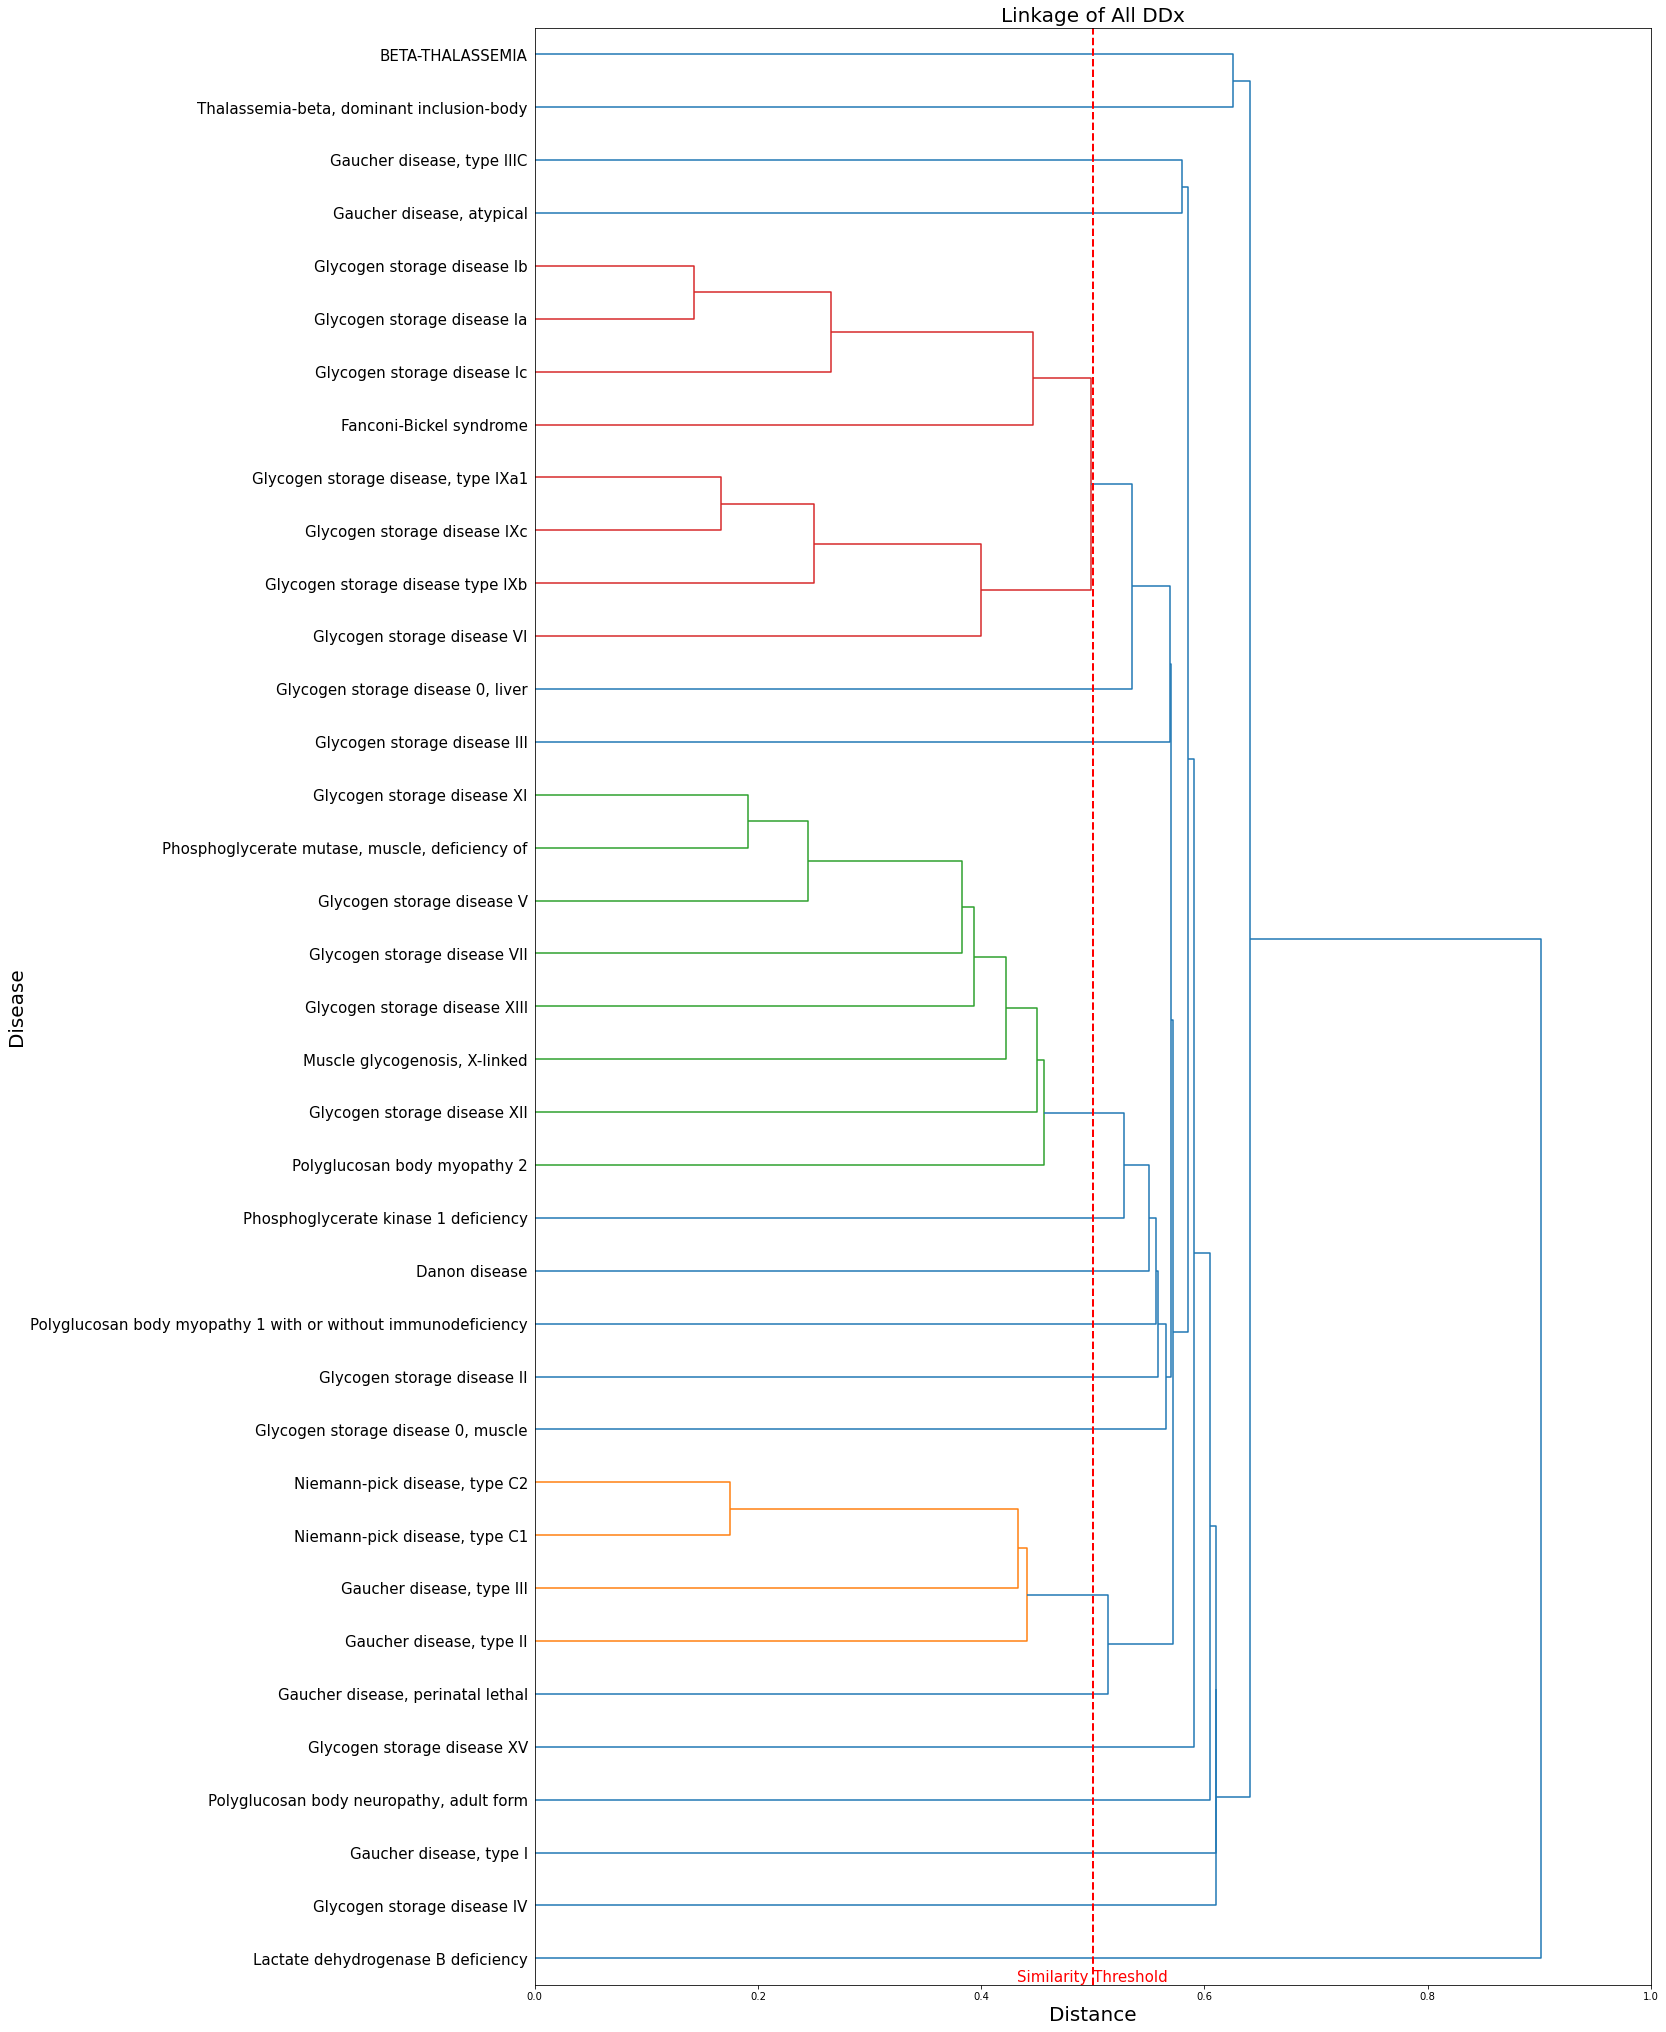

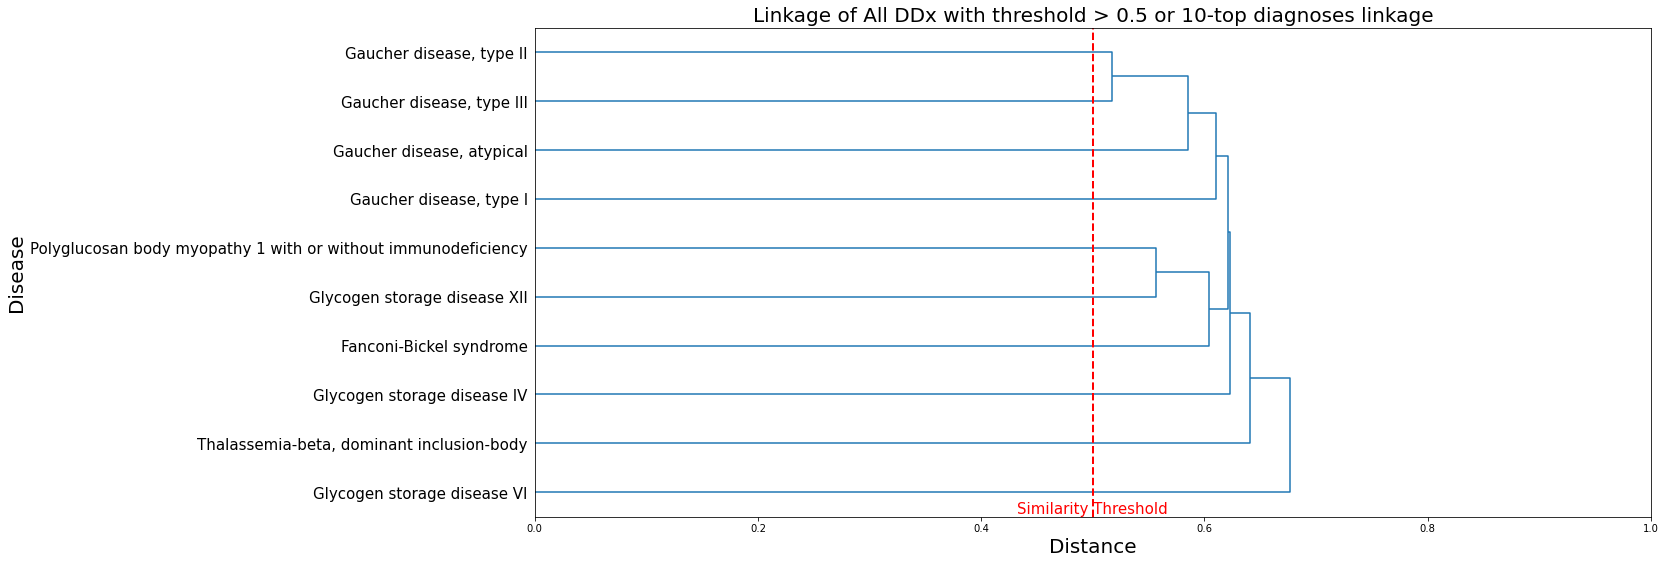

In [244]:
# Split phenotype diagnosis split
hpo_sets, diagnosis_sets = phenotype_diagnosis_split(clinical_data_list)
s_sim, lnk_all, sr_dis_name, lnk_thr, sr_dis_name_thr = omim_hpo_similarity(diagnosis_sets, hpo_sets, threshold=threshold, differential=diffx)

# Plot all similarity in dendogram threshold
lnk_all_dendo = similarity_dendogram(lnk_all, sr_dis_name, title='Linkage of All DDx', threshold=threshold)
lnk_thr_dendo = similarity_dendogram(lnk_thr, sr_dis_name_thr, title='Linkage of All DDx with threshold > ' + str(threshold) + ' or ' + str(diffx) + '-top diagnoses linkage', threshold=threshold)

# Print the result with similarity > threshold
for i in range(len(sr_dis_name_thr)):
    print('Rank', str(i+1), ':', sr_dis_name_thr[i], 'Sim:', s_sim[i])